In [1]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from utilities import *
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda'


In [2]:
focal, all_c2w, all_gt = get_data("../lego")

LOAD DATA ../lego/train


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 48.45it/s]


In [3]:
H, W = all_gt[0].shape[:2]

In [4]:
rays_or_dir = [get_rays_np(H,W, focal, c2w) for c2w in all_c2w]

In [5]:
camera_centers = get_cameras_centers(rays_or_dir)

In [6]:
class VoxelGrid():
    def __init__(self, size=128, bound_w=1):
        self.size = size
        self.bound_w = bound_w
        self.colors =  Variable(torch.rand((size*size*size,3)).to(device), requires_grad=True)
        self.opacities =  Variable(torch.rand((size*size*size)).to(device), requires_grad=True)
        x = np.linspace(-bound_w,bound_w,size)
        y = np.linspace(-bound_w,bound_w,size)
        z = np.linspace(-bound_w,bound_w,size)
        self.meshgrid = np.meshgrid(x,y,z)

    def in_bounds_indices(self, p):
        ''' input: Nx3 array
            output: index of valid arrays'''
        in_x = (p[...,0]>=0)*(p[...,0]<self.size)
        in_y = (p[...,1]>=0)*(p[...,1]<self.size)
        in_z = (p[...,2]>=0)*(p[...,2]<self.size)
        return in_x*in_y*in_z
    
    def descartes_to_indices(self, p):
        ''' input: Nx3 array, 3D points
            out: Nx3 array, 3D indices in [0, size['''
        q = torch.zeros_like(p)
        q[..., 0] = (p[...,0]+self.bound_w)/(2*self.bound_w)*(self.size-1)
        q[..., 1] = (p[...,1]+self.bound_w)/(2*self.bound_w)*(self.size-1)
        q[..., 2] = (p[...,2]+self.bound_w)/(2*self.bound_w)*(self.size-1)
        return q

    def flatten_3d_indices(self, inds_3d):
        ''' input: Nx3 array of indices
            out: N array of flatten indices'''
        return inds_3d[...,0] + self.size*inds_3d[...,1] + self.size*self.size*inds_3d[...,2]

    def render_ray(self, p):
        # extract valid indices
        inds_3d = self.descartes_to_indices(p)
        valid_inds = torch.arange(len(p))[self.in_bounds_indices(torch.floor(inds_3d))]

        # meshgrid coordinates
        mesh_coords = self.flatten_3d_indices(inds_3d[valid_inds].long())

        colors = self.colors[mesh_coords]
        opacities = self.opacities[mesh_coords]
        cumsum_opacities = torch.cumsum(opacities, 0)
        
        transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
        return (colors*transp_term[..., None]).sum(0)
    
    def render_rays(self, p):
        # extract valid indices
        inds_3d = self.descartes_to_indices(p)
        in_bounds = self.in_bounds_indices(torch.floor(inds_3d).to(device))
        # meshgrid coordinates
        mesh_coords = self.flatten_3d_indices(inds_3d.long())
        mesh_coords[torch.logical_not(in_bounds)] = 0
        
        colors = self.colors[mesh_coords]
        opacities = self.opacities[mesh_coords]*in_bounds.float()
        cumsum_opacities = torch.cumsum(opacities, 1)
        
        transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
        return (colors*transp_term[..., None]).sum(1)

    def update_grads(self, lr):
        self.colors.data -= lr * self.colors.grad.data
        self.colors.grad.data.zero_()
        self.opacities.data -= lr * self.opacities.grad.data
        self.opacities.grad.data.zero_()

In [93]:
VG = VoxelGrid(10, 1)
xx,yy,zz = VG.meshgrid

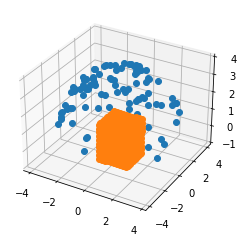

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:,1], camera_centers[:,2], 'o')
ax.plot( xx.flatten(),yy.flatten(),zz.flatten(), 'o')


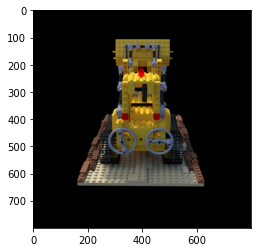

In [95]:
plt.imshow(all_gt[0])

In [96]:
rays_or_dir = get_rays_np(H,W, focal, all_c2w[0])

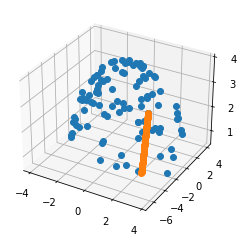

In [97]:
p = rays_or_dir[0][0,0]+ np.arange(100)[:, None]/10*rays_or_dir[1][0,0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:,1], camera_centers[:,2], 'o')
ax.plot( p[:,0], p[:,1], p[:,2], 'o')

In [98]:
# target_im = all_gt[0]
# rays = rays_or_dir[0][..., None] + np.arange(100)/10*rays_or_dir[1][..., None]

red = 8
target_im = all_gt[0][::red,::red,:]
rays = rays_or_dir[0][::red,::red,:, None] + np.arange(100)/10*rays_or_dir[1][::red, ::red,:, None]
print(rays.shape)


(100, 100, 3, 100)


In [102]:

losses=[]
im_w = target_im.shape[0]
tensor_ray = torch.tensor(rays, dtype=torch.float32).to(device).permute((0,1,3,2)).view((im_w*im_w,im_w,3))
tensor_target_im = torch.tensor(target_im, dtype=torch.float32).to(device).view((im_w*im_w,3))
for i in tqdm(range(20)):
    pix_estims = VG.render_rays(tensor_ray)
    loss = ((pix_estims-tensor_target_im)**2).sum()

    loss.backward()
    losses.append(loss.item())

    VG.update_grads(0.001)


100%|███████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


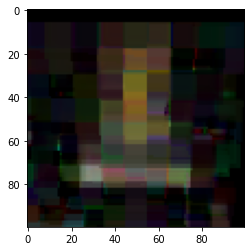

In [103]:
n_red = 5
im_w = target_im.shape[0]
tensor_ray = torch.tensor(rays, dtype=torch.float32).to(device).permute((0,1,3,2)).view((im_w*im_w,im_w,3))
new_im = VG.render_rays(tensor_ray).view((im_w,im_w,3)).cpu().detach().numpy()

plt.imshow(new_im)

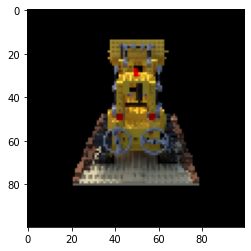

In [227]:
plt.imshow(target_im)

(array([6.3974e+04, 1.3000e+01, 6.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.73184019,  5.09885725, 10.9295547 , 16.76025215, 22.59094959,
        28.42164704, 34.25234449, 40.08304194, 45.91373938, 51.74443683,
        57.57513428]),
 <BarContainer object of 10 artists>)

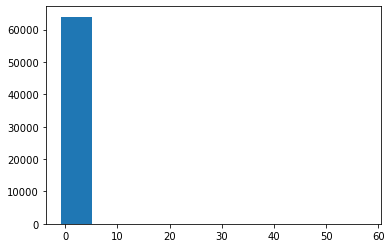

In [228]:
plt.hist(VG.opacities.tolist())

In [42]:
# target_im = all_gt[0]
# rays = rays_or_dir[0][..., None] + np.arange(100)/10*rays_or_dir[1][..., None]

red = 8
target_ims = [gt[::red,::red,:] for gt in all_gt]
rays_or_dir = [get_rays_np(H,W, focal, c2w) for c2w in all_c2w]
rays = [e[0][::red,::red,:, None] + np.arange(100)/10*e[1][::red, ::red,:, None] for e in rays_or_dir]




In [43]:
im_w = target_ims[0].shape[0]
im_w

100

In [44]:

losses=[]
im_w = target_im.shape[0]
tensor_rays = [torch.tensor(ray, dtype=torch.float32).to(device).permute((0,1,3,2)).view((im_w*im_w,im_w,3)) for ray in rays]
tensor_target_ims = [torch.tensor(target_im, dtype=torch.float32).to(device).view((im_w*im_w,3)) for target_im in target_ims]




In [82]:
VG = VoxelGrid(20, 1.5)
xx,yy,zz = VG.meshgrid

In [89]:

N_ims = len(target_ims)
losses=[]

epochs = 100

for _ in tqdm(range(epochs)):
    image_ind = np.random.randint(0, N_ims)
    
    pix_estims = VG.render_rays(tensor_rays[image_ind])
    loss = ((pix_estims-tensor_target_ims[image_ind])**2).sum()

    loss.backward()
    losses.append(loss.item())

    VG.update_grads(0.001)




100%|█████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


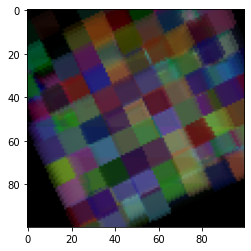

In [113]:
image_ind=7
new_im = VG.render_rays(tensor_rays[image_ind]).view((im_w,im_w,3)).cpu().detach().numpy()

plt.imshow(new_im)

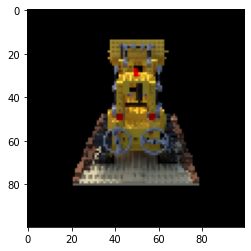

In [91]:
plt.imshow(target_ims[image_ind])

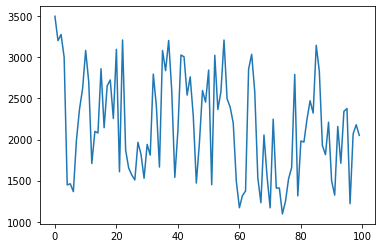

In [92]:
plt.plot(losses)